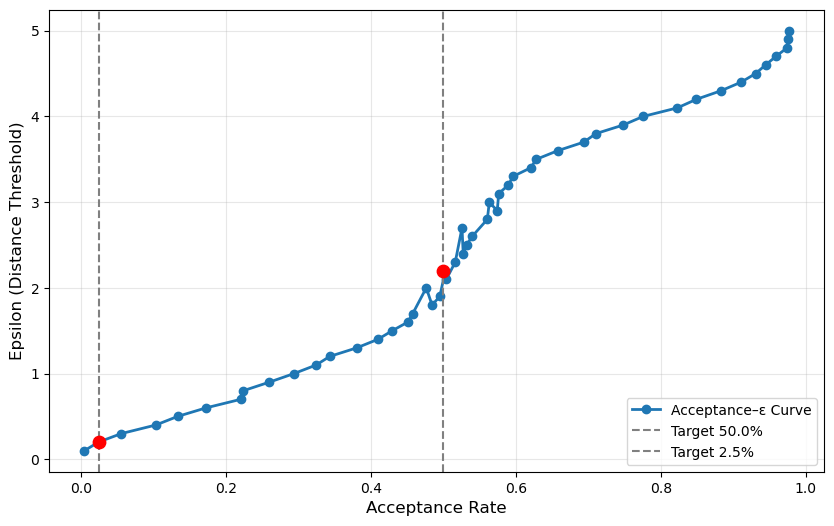

Calibrated epsilon values: {'50.0%': 2.2, '2.5%': 0.2}

Model Performance Summary:
- Quadratic: RMSE = 0.0405 (Weight = 0.329, Accepted = 107)
- Exponential: RMSE = 0.0568 (Weight = 0.333, Accepted = 18)
- Hyperbolic: RMSE = nan (Weight = 0.000, Accepted = 0)
- Logarithmic: RMSE = nan (Weight = 0.000, Accepted = 0)
- Cubic: RMSE = 0.0390 (Weight = 0.337, Accepted = 67)

Weighted Ensemble RMSE: 0.0280
Predicted Best Model: Cubic
Actual Best Model: Cubic


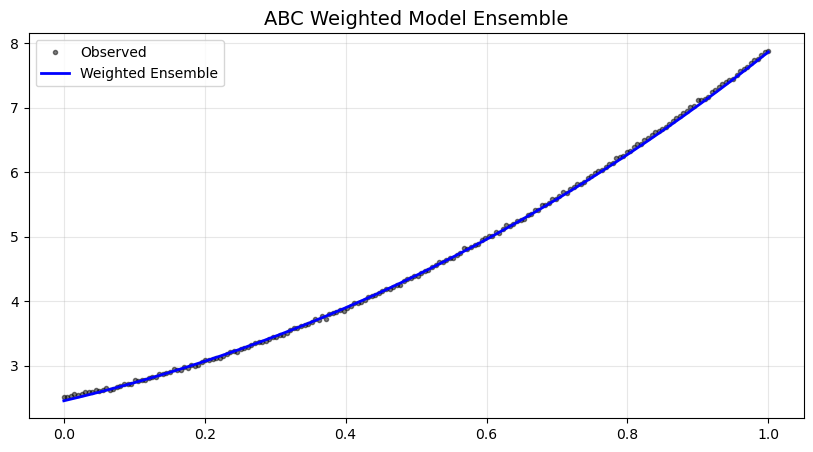

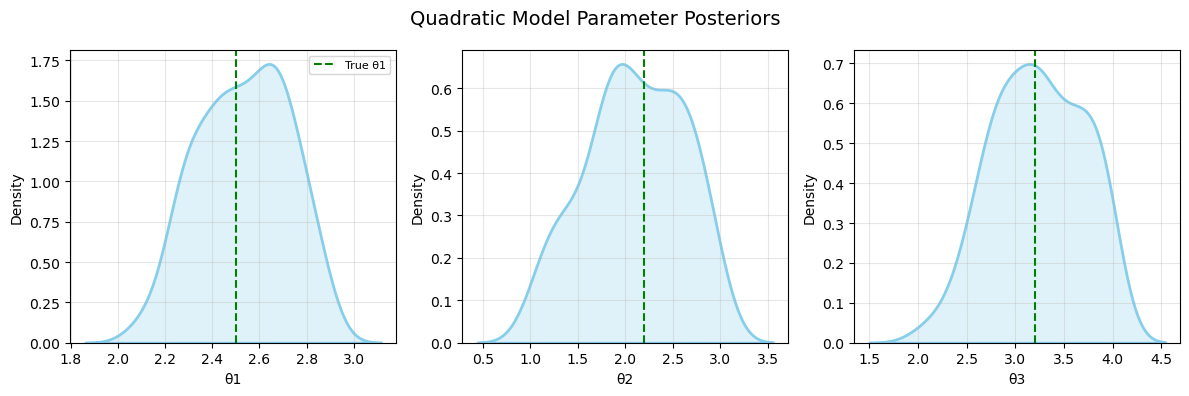

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


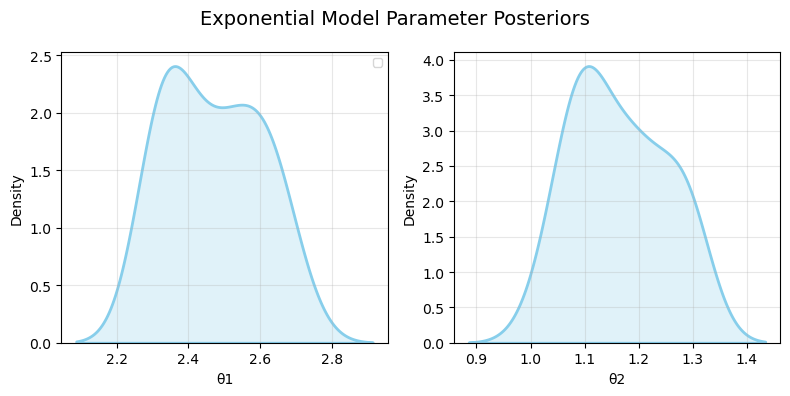

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


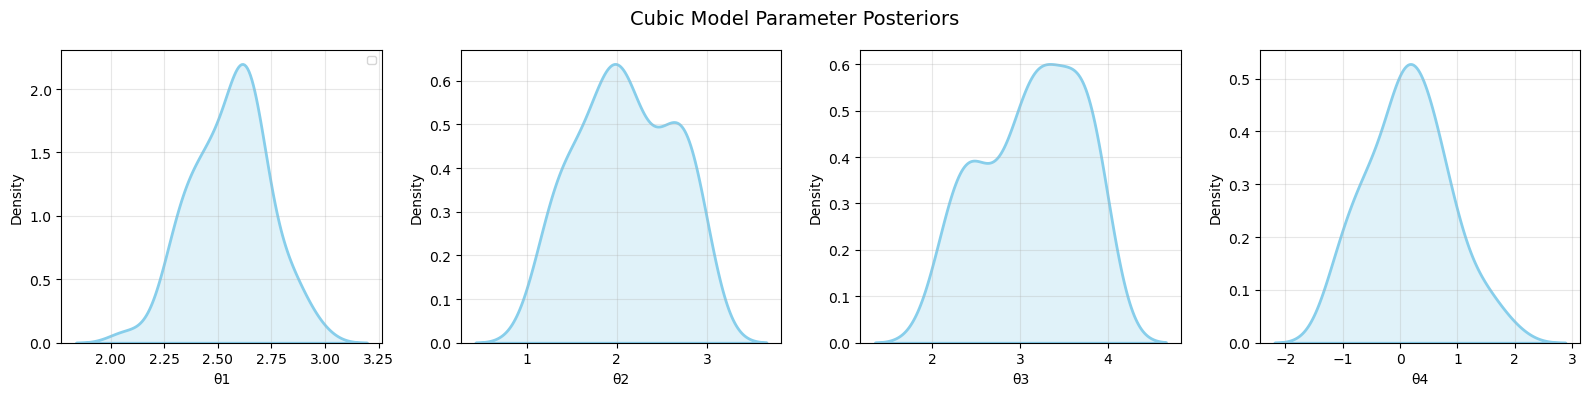

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import seaborn as sns

def model_quadratic(x, theta):
    return theta[0] + theta[1] * x + theta[2] * x**2

def model_cubic(x, theta):
    return theta[0] + theta[1] * x + theta[2] * x**2 + theta[3] * x**3

def model_exponential(x, theta):
    a, b = theta
    return a * np.exp(b * x)

def model_hyperbolic(x, theta):
    a, b = theta
    return a / (b * x + 1)

def model_logarithmic(x, theta):
    a, b = theta
    return a * np.log(b * x + 1)

MODELS = {
    1: {"name": "Quadratic", "func": model_quadratic, "dim": 3, "prior": [(1, 3), (1, 3), (2, 4)]},
    2: {"name": "Exponential", "func": model_exponential, "dim": 2, "prior": [(1.0, 3.0), (0.5, 2.5)]},
    3: {"name": "Hyperbolic", "func": model_hyperbolic, "dim": 2, "prior": [(1.0, 3.0), (0.1, 2.0)]},
    4: {"name": "Logarithmic", "func": model_logarithmic, "dim": 2, "prior": [(1.0, 3.0), (0.1, 2.0)]},
    5: {"name": "Cubic", "func": model_cubic, "dim": 4, "prior": [(1, 3), (1, 3), (2, 4), (-2, 2)]}
}

def calibrate_epsilon_multi(y_obs, models, x, n_samples=3000, targets=[0.5, 0.025]):
    epsilons = np.linspace(0.1, 5, 50)
    acceptance_rates = []
    for eps in epsilons:
        accepted = 0
        for _ in range(n_samples):
            model_id = np.random.choice(list(models.keys()))
            model = models[model_id]
            theta = [np.random.uniform(low, high) for (low, high) in model["prior"]]
            y_sim = model["func"](x, theta)
            dist = np.sqrt(mean_squared_error(y_obs, y_sim))
            if dist < eps:
                accepted += 1
        acceptance_rates.append(accepted / n_samples)
    acceptance_rates = np.array(acceptance_rates)

    plt.figure(figsize=(10, 6))
    order = np.argsort(acceptance_rates)
    plt.plot(acceptance_rates[order], epsilons[order], marker='o', lw=2, color='tab:blue', label='Acceptance–ε Curve')

    eps_map = {}
    for t in targets:
        idx = np.argmin(np.abs(acceptance_rates - t))
        eps_t = epsilons[idx]
        eps_map[f"{t*100:.1f}%"] = eps_t
        plt.axvline(t, linestyle='--', color='gray', label=f'Target {t*100:.1f}%')
        plt.scatter(t, eps_t, color='red', s=80, zorder=3)  # no label here, so not in legend

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.xlabel("Acceptance Rate", fontsize=12)
    plt.ylabel("Epsilon (Distance Threshold)", fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()

    print("Calibrated epsilon values:", eps_map)
    return eps_map


def calculate_weights(perf, models, temp=0.5):
    scores = {}
    for mid, p in perf.items():
        if p["rmse"]:
            scores[mid] = np.exp(-np.median(p["rmse"]) / temp)
        else:
            scores[mid] = 0
    total = sum(scores.values())
    return {mid: (s / total if total > 0 else 1 / len(models)) for mid, s in scores.items()}

def abc_rjmcmc_adaptive(x, y_obs, models, epsilon, n_iter=5000, explore_frac=0.2):
    model_perf = {k: {"rmse": [], "params": []} for k in models}
    n_explore = int(n_iter * explore_frac)
    for i in range(n_iter):
        if i < n_explore:
            model_id = np.random.choice(list(models.keys()))
        else:
            weights = calculate_weights(model_perf, models)
            model_id = np.random.choice(list(weights.keys()), p=list(weights.values()))
        model = models[model_id]
        theta = [np.random.uniform(low, high) for (low, high) in model["prior"]]
        y_sim = model["func"](x, theta)
        dist = np.sqrt(mean_squared_error(y_obs, y_sim))
        if dist < epsilon:
            model_perf[model_id]["rmse"].append(dist)
            model_perf[model_id]["params"].append(theta)
    return model_perf

def run_model_selection_framework(x, y_obs, models=MODELS):
    eps_map = calibrate_epsilon_multi(y_obs, models, x)
    epsilon = eps_map["2.5%"]
    model_perf = abc_rjmcmc_adaptive(x, y_obs, models, epsilon)
    weights = calculate_weights(model_perf, models)
    weighted_pred = np.zeros_like(y_obs)
    model_rmse = {}
    for mid, perf in model_perf.items():
        name = models[mid]["name"]
        if not perf["params"]:
            model_rmse[name] = np.nan
            continue
        best_idx = np.argmin(perf["rmse"])
        best_theta = perf["params"][best_idx]
        pred = models[mid]["func"](x, best_theta)
        rmse = np.sqrt(mean_squared_error(y_obs, pred))
        model_rmse[name] = rmse
        weighted_pred += weights[mid] * pred
    weighted_rmse = np.sqrt(mean_squared_error(y_obs, weighted_pred))
    predicted_best = models[max(weights, key=weights.get)]["name"]
    actual_best = min(model_rmse, key=lambda k: model_rmse[k] if not np.isnan(model_rmse[k]) else np.inf)
    print("\nModel Performance Summary:")
    for m, rmse in model_rmse.items():
        model_id = next((mid for mid, model in models.items() if model["name"] == m), None)
        weight = weights.get(model_id, 0) if model_id is not None else 0
        accepted = len(model_perf[model_id]["params"]) if model_id is not None else 0
        print(f"- {m}: RMSE = {rmse:.4f} (Weight = {weight:.3f}, Accepted = {accepted})")
    print(f"\nWeighted Ensemble RMSE: {weighted_rmse:.4f}")
    print(f"Predicted Best Model: {predicted_best}")
    print(f"Actual Best Model: {actual_best}")
    plt.figure(figsize=(10, 5))
    plt.plot(x, y_obs, 'k.', alpha=0.5, label='Observed')
    plt.plot(x, weighted_pred, 'b-', lw=2, label='Weighted Ensemble')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.title("ABC Weighted Model Ensemble", fontsize=14)
    plt.show()
    return model_perf, weights

def plot_all_model_posteriors(perf, models, true_coeffs=None):
    for mid, model in models.items():
        model_name = model["name"]
        params = np.array(perf[mid]["params"])
        if params.size == 0:
            continue
        plt.figure(figsize=(4 * model["dim"], 4))
        for i in range(model["dim"]):
            plt.subplot(1, model["dim"], i + 1)
            sns.kdeplot(params[:, i], fill=True, color='skyblue', lw=2)
            if true_coeffs is not None and mid == 1 and i < len(true_coeffs):
                plt.axvline(true_coeffs[i], color='green', linestyle='--', label=f"True θ{i+1}")
            plt.xlabel(f"θ{i+1}")
            if i == 0:
                plt.legend(fontsize=8)
            plt.grid(alpha=0.3)
        plt.suptitle(f"{model_name} Model Parameter Posteriors", fontsize=14)
        plt.tight_layout()
        plt.show()

np.random.seed(42)
x = np.linspace(0, 1, 200)
true_y = 2.5 + 2.2 * x + 3.2 * x**2
y_obs = true_y + 0.01 * np.std(true_y) * np.random.randn(len(x))
model_perf, weights = run_model_selection_framework(x, y_obs, MODELS)
plot_all_model_posteriors(model_perf, MODELS, true_coeffs=[2.5, 2.2, 3.2])
